# Introduction

This file is based on [Open Data Science materials](https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/tutorials/Catastrophic_Events_with_Scipy.ipynb).

Previously in the bootcamp we were trying to make all the datapoints fit the average line. Minimization of the distance to average is extremely important, because this way we can predict how the process will behave in *normal* situation - in 90%, 95% or 99% of cases. But sometimes we actually need to predict the extreme cases. Here we are going to talk about **Extreme Value** statistics.

At the end of that short but preciser tutorial, you'll understand what is a GEV (Generalized extreme value distribution) and how to fit it on your data in python.

Extreme values statistics is different from "average" statistics in this regard, indeed as we will see, we here try to model something for which we have no data! You will see soon what we mean by that. Before getting there I want to show you why extreme values modelling is an actual problem, of high interest for insurance companies and public services. Let's start with some real life examples.

If you ever been to Montpellier, you know that usually it is very hot there. Annual rain level is not that high, but sometimes you end up in outliers like this:
<img src='https://pix.avax.news/avaxnews/b2/a5/0001a5b2_medium.jpeg' width='480'>

Same situation with Paris. It is not common to have Seine leaving its borders, but the whole city is blocked with almost no access to the other side of the river if it happens:
<img src='https://s.france24.com/media/display/8b0b5afa-fca0-11e8-9277-005056bff430/w:1280/p:16x9/paris_flood.webp' width='480'>

According to stats, airplanes are considered as the safest mean of transportation. Therefore, almost everybody knows about every single airplane crash. But is there a way to predict it?
<img src='https://d.newsweek.com/en/full/1092492/08-28-nepal-jet.jpg' width='480'>

And yeah, I would also love to predict whether my lovely *Bullet* will win to nil.
<img src='https://specials-images.forbesimg.com/imageserve/1160488533/960x0.jpg?fit=scale' width='480'>

# Probability of rare event

## First some data

We can get our data from [NASA](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1136). Here we have 357 datapoints about CO2 Exchange in River Systems Across the Amazon Basin: 2004-2007.

I will share the file upon request.

Let's imagine data contains trimestrial data on FCO2 level.

In [97]:
os.chdir(r'C:\Users\eldii\Downloads\CD06_CO2_Exchange_1136')

In [167]:
df=pd.read_csv('CO2_chamber_flux_data.csv', skiprows=42,header=0)

In [168]:
df=pd.read_csv('FCO2.csv')

In [169]:
df.columns

Index(['FCO2 '], dtype='object')

Here we are going to study the following parameter: `Air-water CO2 gas exchange flux reported in umol CO2/m2/s`.  
Why is it important? Currently we all know that humanity is polluting our air with all types of carbon emmisions. We know that we are polluting ocean waters with plastic. But what is important - we also pollute water with carbon emmisions. It sucks... We need to prevent it. First step is to measure and track the value of our parameter. 

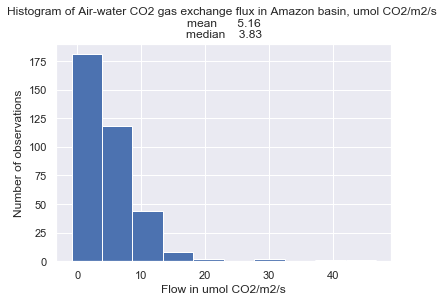

In [170]:
df['FCO2 '].hist()
plt.xlabel('Flow in umol CO2/m2/s');
plt.ylabel('Number of observations');
plt.title(f"Histogram of Air-water CO2 gas exchange flux in Amazon basin, umol CO2/m2/s \n{df['FCO2 '].agg(['mean','median']).round(2).to_string()}");

In [171]:
flux=df['FCO2 ']

We see that most flows are under 5 umol CO2/m2/s, a significant part is under 10 umol CO2/m2/s, but we also see that even if the flows are in general low, it can also become 40 umol CO2/m2/s high.

This is typically a problem where we cannot use the average value to represent anything, since most flows are under 10 CO2/m2/s, and some are very high.

### Warm-up questions: what is the probability to observe a flow superior to 15 CO2/m2/s ? Then 30 CO2/m2/s ?

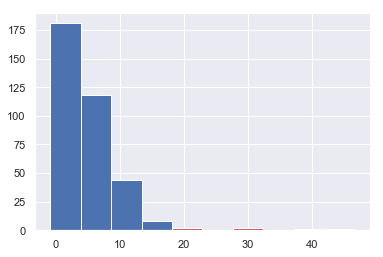

In [172]:
n, bins, patches = plt.hist(flux)
for i, x in enumerate((bins > 15)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')

plt.show()

The step for the last bin represent one flow, this way we even can count visually the population in all the red bins :

$$ \begin{equation} P(X>15)≃\frac{nb(Xi>15)}{n}=\frac{9}{357}=\frac{3}{119} \end{equation} $$
Using our empiric data we compute this way the probability to have a flow superior to 15 CO2/m2/s, which tells us that we have a flow of this type in average every 3.3 years. (1/proba/12 month)

Nothing unusual yet, right ?...

In [214]:
1/(3/119)/12

3.3055555555555554

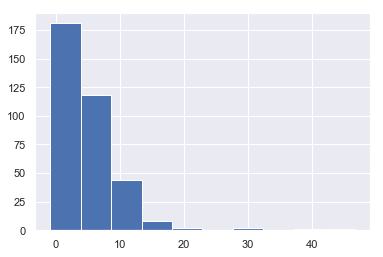

In [190]:
n, bins, patches = plt.hist(flux)
for i, x in enumerate((bins > 30)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')

plt.show()

$$ \begin{equation} P(X>30)≃\frac{nb(Xi>30)}{n}=\frac{3}{357}=\frac{1}{119} \end{equation} $$

Here again we can answer (hardly) that we therefore have a flow superior to 30 CO2/m2/s in average every 9.9 years.

Ok enough played, let's come to the annoying question :

"You have no way to answer" question: Now, what is the probability to observe such a flow superior to 50 CO2/m2/s?

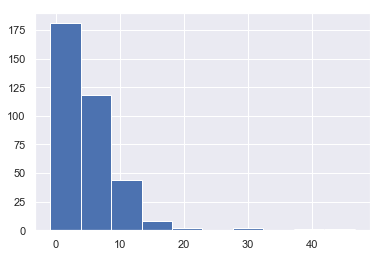

In [227]:
n, bins, patches = plt.hist(flux)
for i, x in enumerate((bins > 50)):
    if x and i < len(bins)-1:
        patches[i].set_fc('r')
        
plt.show()

$$ \begin{equation} P(X>50)≃\frac{nb(Xi>50)}{n}=\frac{0}{357}=0 \end{equation} $$

Based on our dataset, this event is impossible. DO we really believe this statement? Thanks to human activity, we will end up there someday...

### Partial Conclusion : we cannot estimate the probability of such a flow with the histogram!

Here comes the punchline - we don't have data, but we still want to calculate the probability of specific outcome. How can we do that?  

In statistical modelling, usually, we train an algorithm with a dataset that is supposed to have the same distribution as the testing data, in other words we have datas for what we want to model. Extreme value theory comes into play here:

"Classic" statistics doesn't allow to compute probabilities such that $P(X>x)$ when x is beyond the maximum of our observations.
Hopefully Extreme value theory gives us tools to extrapolate beyond our datas.
A "famous" joke illustrates this problematic: during the night, someone is squatting at the foot of a lamppost, and a passerby asks him: "What are you doing?" "I'm looking for my keys." "Are you certain that you lost them around the lamppost?", asks again the passerby. "No, but, in fact, that's the only lighted place."

Extreme value statistics is kind of like this joke, we want to make statistics where there is no light, where there is no data.

# Theory: Extreme values theorem / Implementation: scipy.stats.genextreme
The extreme values theorem can be seen as the analog of the central limit theorem. For a random variable $X$ and it's maximum over $n$ observations: $X_{n,n}$.

Under general conditions on the distribution of $X$, there is three parameters $a_{n}$, $b_{n}$ and $\gamma$ such that:
$$\lim_{n -> +\infty} P\left(\frac{X_{n,n} - a_{n}}{b_{n}} \leq x\right) = H_{\gamma}(x)$$
where:
$$ H_{\gamma}(x) = \begin{cases}
\exp(-\exp(-x))            &\text{for } \gamma = 0\\
\exp(-(1+\gamma x)^{-1/\gamma}_{+})   &\text{for } \gamma != 0
\end{cases}$$

with $y_{+} = max(0,y)$.

Useful vocabulary:
- $H_{\gamma}$ is the **generalized extreme value (GEV) distribution**.
- $\gamma$ is the shape parameter
- $a_{n}$ and $b_{n}$ are scaling parameters.

With different values of $\gamma$ there is a type I, type II and type III GEV, also called the Gumbel ($\gamma=0$), Fréchet ($\gamma >0$) and Weibull ($\gamma <0$) distributions.

If you have a random variable $X$ and study the distribution of it's maximum over a number of samples $X_{n,n}$, this distribution must belong and must \"fall\" in the domain of attraction of one of these 3 types of GEV.

(More here : https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution.)

**We will use the genextreme class from scipy**

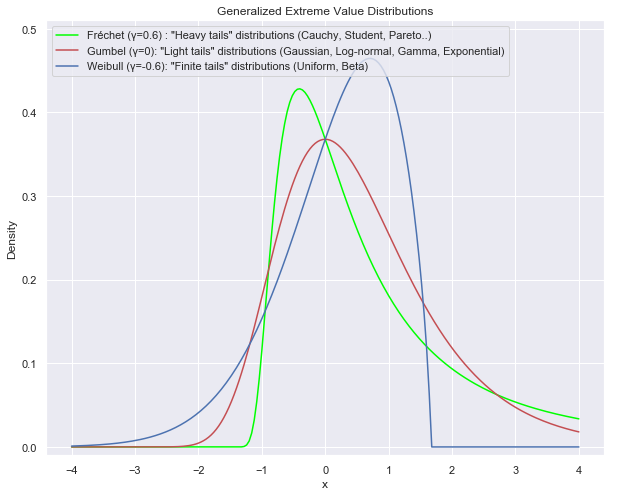

In [191]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.stats import genextreme 

plt.figure(figsize=(10,8)) 
x = np.linspace(-4, 4, 201) 
#Please notice that in genextreme the shape parameter (gamma) equals to -gamma in our equations here
plt.plot(x, genextreme.pdf(x, -0.6), color='#00FF00', label='Fréchet (\u03B3=0.6) : "Heavy tails" distributions\
 (Cauchy, Student, Pareto..)') 
plt.plot(x, genextreme.pdf(x, 0.0), 'r', label='Gumbel (\u03B3=0): "Light tails" distributions\
 (Gaussian, Log-normal, Gamma, Exponential)') 
plt.plot(x, genextreme.pdf(x, 0.6), 'b', label='Weibull (\u03B3=-0.6): "Finite tails" distributions\
 (Uniform, Beta)') 
plt.ylim(-0.01, 0.51) 
plt.legend(loc='upper left') 
plt.xlabel('x') 
plt.ylabel('Density') 
plt.title('Generalized Extreme Value Distributions') 
plt.show() 

Let's use again our dataset of Nidd River, we will fit a GEV on it and estimate extreme quantiles.
In pratice we will estimate the three parameters $\gamma$, $a_{n}$ and $b_{n}$ such that:
$$P(X_{n,n} \leq x) \simeq H_{\gamma}(\frac{x-a_{n}}{b_{n}})$$

So first we need to turn our trimestrial data, that is our observations of $X$ into observations of X_{n,n}, lets say yearly maximums, we will create a vector of observations by taking the maximum flow for each year:

In [239]:
for i in range(0, int(flux.shape[0]/4)):
    if i == 0:
        df_max = flux.iloc[4*i:4*i+4].max()
    else:
        df_max = np.append(df_max, flux.iloc[4*i:4*i+4].max())

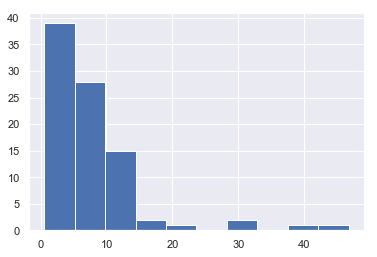

In [242]:
plt.hist(df_max);

In [243]:
shape, loc, scale = genextreme.fit(df_max) 

In [244]:
-shape

0.3050633745250748

This shape parameters tells us that the GEV is a Fréchet type, with a heavy tails, which means our river's flow can sometimes be very big, we better be careful and construct strong flood protections.

We can plot the fitted distribution to see that it makes sense

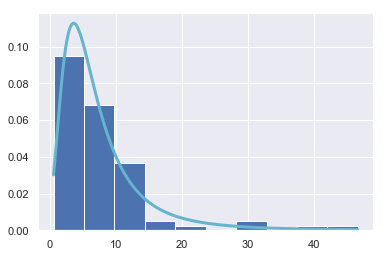

In [245]:
plt.hist(df_max, normed=True); 

x = np.linspace(df_max.min(), df_max.max(), 1000) 
y = genextreme.pdf(x, shape, loc, scale) 
plt.plot(x, y, 'c', linewidth=3);

**We can now calculate the probability that the river's flow exceeds 50 CO2/m2/s:**
Indeed, because the observations of $X$ that we have are independant, hence:
$P(X_{n,n} \leq x) = F^{n}(x)$
and from the extreme value theorem this means $F(x) \simeq H_{\gamma}^{1/n}(\frac{x-a_{n}}{b_{n}})$, taking the log and developping around $\log(1+u)$ gives :
$P(X\geq x) \simeq -\frac{1}{n}\log H_{\gamma}(\frac{x-a_{n}}{b_{n}})$
Therefore we now have an approximation of the survival function in tail:

$$ \hat{F}(x) = P(X\geq x) \simeq \begin{cases}
\frac{1}{n}[1+\gamma(\frac{x-a_{n}}{b_{n}})]^{-1/\gamma}        &\text{for } \gamma != 0\\
\frac{1}{n}\exp(-(\frac{x-a_{n}}{b_{n}}))   &\text{for }
\gamma = 0
\end{cases}
$$

In [246]:
def surv(x, n, shape, loc, scale):
    if shape != 0:
        surv = 1/n * (1 - shape*(x-loc)/scale) ** (1/shape)
    else:
        surv = 1/n * np.exp(-(x-loc)/scale)
    return surv

In [259]:
surv(50, 4, shape, loc, scale)


0.0012160887419984492

In [263]:
1/surv(50, 4, shape, loc, scale)/4

205.5771025304984

In [261]:
1/surv(50, 4, shape, loc, scale)

822.3084101219936

So the probability that the trimestrial flow will be greater than $50$ CO2/m2/s is  about 0.001, which means one trimester in 822, which means one time in 205.6 years! *Instead of \"never\" before*

We can also answer questions like : what is the river's CO2/m2/s that we expect to meet only once in a century, because we also have the inverse of the survival function :

$$ \hat{F}^{-1}(x)\simeq \begin{cases}
a_{n} + \frac{b_{n}}{\gamma}[(np)^{-\gamma} - 1]         &\text{for } \gamma != 0\\
a_{n} - b_{n}\log(np)   &\text{for }\gamma = 0
\end{cases}
$$

In [250]:
def invsurv(p, n, shape, loc, scale):
    if shape != 0:
        invsurv = loc + scale/-shape * ((n*p)**shape - 1)
    else:
        invsurv = loc - scale * np.log(n*p)
    return invsurv

In [262]:
invsurv(1/400, 4, shape, loc, scale)

38.81576585273336

Here we computed the flow that we would get every 400 trimester, that is every century : 38.82 CO2/m2/s!